In [118]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import torch
import os

In [119]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
#data_dir = "/Users/peter/repos/qu/results/2024-06-13_17-02-36_masked-image-text/output"
#session_label = "2024-11-21_15-42-26_with-cm-logging6"
session_label = "2024-12-05_16-34-39_output-test-predictions"
output_epoch = "epoch_18"
data_dir = f"/Users/peter/repos/qu/results/{session_label}/output"
if not output_epoch == "":
    data_dir = os.path.join(data_dir, output_epoch)

# Read and concatenate the data sets (just use all of them for now)
df1 = pd.read_csv(os.path.join(data_dir, "df_train_predictions.csv"))
df2 = pd.read_csv(os.path.join(data_dir, "df_validation_predictions.csv"))
df3 = pd.read_csv(os.path.join(data_dir, "df_test_predictions.csv"))
df_combined = pd.concat([df1, df2])
print(df_combined.shape)
print(df1.shape, df2.shape)
print(df_combined.columns.values)

print(df_combined['h_score'].value_counts())

print('patient count:', df_combined['anon_id'].nunique())
print('exam count:', df_combined['exam_id'].nunique())

# Remove diagnosis 99 (ignored in 2nd stage model)
print(df_combined['diagnosis'].value_counts())
df_combined = df_combined[df_combined['diagnosis'] != 99]

print(df_combined.shape)

# Drop duplicate entries based on 'patient_id'
unique_patients = df_combined.drop_duplicates(subset='anon_id')
total_count = unique_patients.shape[0]

# Count the number of healthy (0) and diseased (non-0) patients
diagnosis_counts = unique_patients['diagnosis'].apply(lambda x: 'Healthy' if x == 0 else 'Diseased').value_counts()
print(diagnosis_counts)
healthy_count = diagnosis_counts['Healthy']
diseased_count = diagnosis_counts['Diseased']
# percentages
print(f"Total count: {total_count}")
print(f"Healthy: {healthy_count} ({100*healthy_count/total_count:.2f}%)")
print(f"Diseased: {diseased_count} ({100*diseased_count/total_count:.2f}%)")


(73233, 23)
(54069, 23) (19164, 23)
['anon_id' 'exam_id' 'Age_exam' 'Sex' 'Weight' 'Length' 'diagnosis'
 'muscle' 'side' 'z_score' 'h_score' 'image_file' 'has_markers' 'li_x'
 'li_y' 're_x' 're_y' 'id_x' 'id_y' 'bmi' 'prediction'
 'rounded_prediction' 'label']
h_score
1.0    49772
2.0    16420
3.0     6433
4.0      608
Name: count, dtype: int64
patient count: 1475
exam count: 1774
diagnosis
5     32956
0     17024
1      7112
99     6707
2      5855
3      3277
4       281
6        21
Name: count, dtype: int64
(66526, 23)
diagnosis
Diseased    780
Healthy     530
Name: count, dtype: int64
Total count: 1310
Healthy: 530 (40.46%)
Diseased: 780 (59.54%)


In [121]:
# Input
input_column = 'muscle'
input_value_column = 'prediction'
print(df_combined[input_column].value_counts())
#input_values = df[input_column].unique() # all muscles
#input_values = input_values[input_values != 'Extensors'] # remove Extensors
input_values = ['Biceps','RF','TA','GM','VL','Deltoid'] # six most common muscles
value_to_index = {value: idx for idx, value in enumerate(input_values)}
print(value_to_index)

# Output
use_diagnosis = False

muscle
Biceps        8207
TA            7774
GM            7716
VL            6244
Deltoid       5504
FCR           5257
RF            4960
Rectusab      3771
Trap          3338
ID1           3006
Masseter      2957
Digastric     2919
PerT          1794
SCM           1566
Geniohyoid    1463
Extensors       50
Name: count, dtype: int64
{'Biceps': 0, 'RF': 1, 'TA': 2, 'GM': 3, 'VL': 4, 'Deltoid': 5}


In [122]:
# Aggregate the h_scores for each muscle
df_agg_train = df1.groupby(['exam_id', input_column]).agg({'prediction': 'max', 'h_score': 'max', 'diagnosis': 'first'}).reset_index()
df_agg_val = df2.groupby(['exam_id', input_column]).agg({'prediction': 'max', 'h_score': 'max', 'diagnosis': 'first'}).reset_index()
df_agg_test = df3.groupby(['exam_id', input_column]).agg({'prediction': 'max', 'h_score': 'max', 'diagnosis': 'first'}).reset_index()
# df_agg['h_score'] = np.random.normal(2, 1.0, df_agg.shape[0])
# df_agg['h_score'] = 1.0
print(df_agg_train.head(5))
print(df_agg_val.head(5))
print(df_agg_test.head(5))

                            exam_id  muscle  prediction  h_score  diagnosis
0  0037dc33a92f6d45871c3602a20ac322  Biceps    1.959257      1.0          0
1  0037dc33a92f6d45871c3602a20ac322     FCR    1.763558      1.0          0
2  0037dc33a92f6d45871c3602a20ac322      GM    1.711965      1.0          0
3  0037dc33a92f6d45871c3602a20ac322      VL    2.210034      1.0          0
4  0037e1e7de4d3ee36ac5d1c9b3ab8073  Biceps    1.923798      1.0          5
                            exam_id    muscle  prediction  h_score  diagnosis
0  0084fbea6e3650abd91ce4d3ee4d4699    Biceps    1.708533      2.0          5
1  0084fbea6e3650abd91ce4d3ee4d4699   Deltoid    1.517465      2.0          5
2  0084fbea6e3650abd91ce4d3ee4d4699        GM    2.897208      3.0          5
3  0084fbea6e3650abd91ce4d3ee4d4699        RF    1.747876      2.0          5
4  0084fbea6e3650abd91ce4d3ee4d4699  Rectusab    2.517725      2.0          5
                            exam_id   muscle  prediction  h_score  diagnosis

In [123]:
def create_vectors(df):
    input_vectors = {id: np.full(len(input_values), np.NaN) for id in df['exam_id'].unique()}
    label_vectors = {id: False for id in df['exam_id'].unique()}

    # Populate the vectors
    for _, row in df.iterrows():
        exam_id = row['exam_id']
        muscle = row[input_column]
        if muscle in input_values:
            value_index = value_to_index[muscle]
            input_vectors[exam_id][value_index] = row[input_value_column]
            #diagnosis_index = diagnosis_to_index[row['diagnosis']]
            if use_diagnosis:
                label_vectors[exam_id] = row['diagnosis']
            else:
                label_vectors[exam_id] = row['diagnosis'] != 0

    # Convert the dictionary to a DataFrame for easy handling/viewing
    input_df = pd.DataFrame.from_dict(input_vectors, orient='index', columns=input_values)
    label_df = pd.DataFrame.from_dict(label_vectors, orient='index', columns=['diagnosis'])
    return (input_df, label_df)

input_train_df, label_train_df = create_vectors(df_agg_train)
input_val_df, label_val_df = create_vectors(df_agg_val)
input_test_df, label_test_df = create_vectors(df_agg_test)

# Handling missing values in 'input_df' (simple imputation with mean of each column)
# input_df = input_df.apply(lambda x: x.fillna(x.mean()), axis=1)
# input_df = input_df.fillna(0)
#input_df_filled = pd.DataFrame(0, index=np.arange(input_df.shape[0]), columns=input_df.columns)
#print(input_df_filled.head(10))

print(input_train_df.shape, label_train_df.shape)
print(input_val_df.shape, label_val_df.shape)
print(input_test_df.shape, label_test_df.shape)
# display(input_df.head(20))
# display(label_df.head(20))


(1316, 6) (1316, 1)
(458, 6) (458, 1)
(412, 6) (412, 1)


In [124]:
label_values = label_train_df['diagnosis'].unique()
label_values = [str(x) for x in label_values]
print(input_values, label_values)

['Biceps', 'RF', 'TA', 'GM', 'VL', 'Deltoid'] ['False', 'True']


In [125]:
def df_to_masked_array(df):
    # Convert the dataframe to a numpy array
    array = df.to_numpy()

    # Create a mask array, 1.0 where the original array is not NaN, and 0.0 where it is NaN
    mask = np.where(np.isnan(array), 0.0, 1.0)

    # Stack the original array and the mask array to form a new array with 2 channels
    two_channel_array = np.stack((array, mask), axis=-1)

    # Replace NaN values in the original data with 0.0 (or another value of your choice)
    two_channel_array[np.isnan(two_channel_array[..., 0]), 0] = 0.0

    return two_channel_array

X_train_masked = df_to_masked_array(input_train_df)
print(X_train_masked.shape)
X_val_masked = df_to_masked_array(input_val_df)
print(X_val_masked.shape)
X_test_masked = df_to_masked_array(input_test_df)
print(X_test_masked.shape)

(1316, 6, 2)
(458, 6, 2)
(412, 6, 2)


In [ ]:
def boolean_df_to_int_array(df):
    return df.astype(int).to_numpy()

if use_diagnosis:
    y_train_int = label_train_df.astype(int).to_numpy()
    y_val_int = label_val_df.astype(int).to_numpy()
    y_test_int = label_test_df.astype(int).to_numpy()
else:
    y_train_int = boolean_df_to_int_array(label_train_df)
    y_val_int = boolean_df_to_int_array(label_val_df)
    y_test_int = boolean_df_to_int_array(label_test_df)


In [127]:
from torch.utils.data import Dataset, DataLoader

X_train_tensor = torch.tensor(X_train_masked, dtype=torch.float).permute(0, 2, 1)  # Swap the last two dimensions
y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_masked, dtype=torch.float).permute(0, 2, 1)  # Swap the last two dimensions
y_val_tensor = torch.tensor(y_val_int, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_masked, dtype=torch.float).permute(0, 2, 1)  # Swap the last two dimensions
y_test_tensor = torch.tensor(y_test_int, dtype=torch.long)

# Create DataLoader for batching
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from qumia_model2 import MaskedClassifier
from torchsummary import summary

# Define the model, loss function, and optimizer
vector_length = len(input_values)
num_classes = len(label_values) if use_diagnosis else 1
model = MaskedClassifier(vector_length, num_classes)
criterion = nn.CrossEntropyLoss() if use_diagnosis else nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.45]))
optimizer = optim.Adam(model.parameters(), lr=0.005)

# print model summary
summary(model, (2, vector_length))

# Calculate losses
total_loss = 0.0
for inputs, labels in train_loader:
    outputs = model(inputs)
    target = labels.squeeze() if use_diagnosis else labels.float()
    loss = criterion(outputs, target)
    total_loss += loss.item()
print(f'Initial loss: {total_loss/len(train_loader)}')

# Training the model
num_epochs = 20  # Set the number of epochs
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        target = labels.squeeze() if use_diagnosis else labels.float()
        loss = criterion(outputs, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate loss on validation set
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            target = labels.squeeze() if use_diagnosis else labels.float()
            loss = criterion(outputs, target)
            val_loss += loss.item()
        val_loss /= len(val_loader)
    
    # Save the checkpoint
    torch.save(model.state_dict(), f'checkpoint_{epoch+1}.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 64, 6]             192
            Linear-2                   [-1, 64]          24,640
            Linear-3                    [-1, 1]              65
Total params: 24,897
Trainable params: 24,897
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
Initial loss: 0.4368986040353775
Epoch [1/20], Loss: 0.3596, Val Loss: 0.3675
Epoch [2/20], Loss: 0.3532, Val Loss: 0.3575
Epoch [3/20], Loss: 0.3622, Val Loss: 0.3649
Epoch [4/20], Loss: 0.3442, Val Loss: 0.3535
Epoch [5/20], Loss: 0.3718, Val Loss: 0.3685
Epoch [6/20], Loss: 0.3612, Val Loss: 0.3644
Epoch [7/20], Loss: 0.3817, Val Loss: 0.3788
Epoch [8/20], Lo

In [129]:
# Evaluate the model
# model.eval()  # Set the model to evaluation mode
# with torch.no_grad():
#     test_preds = model(X_test_tensor)
#     _, predicted_classes = torch.max(test_preds, 1)
#     matches = (predicted_classes == y_test_tensor.squeeze())
#     accuracy = matches.sum().float().item() / y_test_tensor.size(0)
#     print(f'Accuracy: {accuracy:.4f}')

In [ ]:
import torch
from sklearn.metrics import f1_score

# Load the model at a specific checkpoint
model.load_state_dict(torch.load('checkpoint_4.pth'))

# Set the model to evaluation mode
model.eval()

# Store all the predictions and true labels
test_predictions = []
test_labels = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        if use_diagnosis:
            # Get the predicted classes by finding the max logit value
            _, predicted_classes = torch.max(outputs, 1)
            
            # Collect the predictions and true labels
            test_predictions.extend(predicted_classes.tolist())
            test_labels.extend(labels.tolist())

            correct_predictions += (predicted_classes == labels.squeeze()).sum().item()
            total_predictions += labels.size(0)

        else:

            # Apply sigmoid to the outputs to get the probabilities
            probs = torch.sigmoid(outputs.squeeze())  # Squeeze to remove unnecessary dimensions
            # Convert probabilities to binary predictions using a threshold of 0.5
            
            #predictions = (probs >= 0.5).long()  # Convert to long to match labels type
            
            # Collect the predictions and true labels (for f1 score)
            test_predictions.extend(probs.tolist())
            test_labels.extend(labels.tolist())

            # Compare predictions to true labels (for accuracy)
            #correct_predictions += (predictions == labels.squeeze()).sum().item()
            #total_predictions += labels.size(0)

if use_diagnosis:
    # Calculate the F1 score (choose 'macro', 'micro', or 'weighted' as per your requirement)
    f1_macro = f1_score(test_labels, test_predictions, average='macro')
    f1_micro = f1_score(test_labels, test_predictions, average='micro')
    f1_weighted = f1_score(test_labels, test_predictions, average='weighted')

    print(f'F1 Score (Macro): {f1_macro:.4f}')
    print(f'F1 Score (Micro): {f1_micro:.4f}')
    print(f'F1 Score (Weighted): {f1_weighted:.4f}')
    
    from sklearn.metrics import classification_report
    # all_classes = np.array(label_values)
    # unique_labels = np.unique(np.concatenate((all_classes, all_predictions)))
    # print(unique_labels)
    report = classification_report(test_labels, test_predictions)
    print(report)
    
else:
    pass
    # Calculate the F1 score
    #f1 = f1_score(all_labels, all_predictions, average='binary')  # 'binary' for binary classification tasks
    #print(f'F1 Score: {f1:.4f}')

#print(f'Accuracy: {correct_predictions / total_predictions:.4f}')


In [143]:
from sklearn.metrics import confusion_matrix

# Assuming all_predictions and all_labels are your predicted and true labels, respectively

# Generate the confusion matrix
# cm = confusion_matrix(all_labels, all_predictions)

# # Print the confusion matrix
# print("Confusion Matrix:")
# col_labels = ['', 'Pred 0', 'Pred 1']
# pred_labels = ['True 0', 'True 1']
# for i, label in enumerate(col_labels):
#     print(f"{label:>8}", end=" ")
# print()
# for i, row in enumerate(cm):
#     print(f"{pred_labels[i]:>8}", end=" ")
#     for val in row:
#         print(f"{val:>8}", end=" ")
#     print()

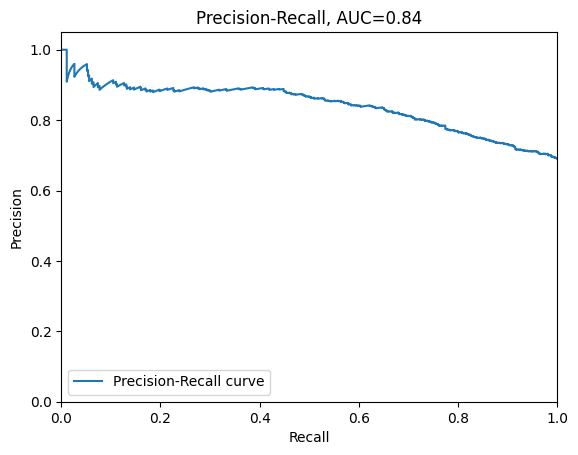

In [144]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt


# Compute Precision-Recall and plot curve, based on test_predictions and test_labels
y_test = np.array(test_labels)
y_score = np.array(test_predictions)

precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

# Plot
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall, AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

# Save the plot
fig_path = f"{session_label}_{output_epoch}_prec-recall.png"
plt.savefig(fig_path)

# AFTER saving
plt.show()

In [145]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# import matplotlib.pyplot as plt

# # # Assuming you have your features in X and target in y
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Binarize the output
# y_test = label_binarize(y_test, classes=[0, 1])

# # Train your classifier and predict probabilities
# # clf.fit(X_train, y_train)
# y_score = clf.predict_proba(X_test)

# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
# roc_auc = auc(fpr, tpr)

# # Plot
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic example')
# plt.legend(loc="lower right")
# plt.show()